In [32]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import requests, datetime, json, numpy as np

# Enable inline plotting
%matplotlib inline

In [33]:
def fetchData(pair, limit=5000, tf='H4'):  
    
    url='https://api-fxtrade.oanda.com/v1/candles?instrument=%s&count=%s&candleFormat=midpoint&granularity=%s&dailyAlignment=0&alignmentTimezone=America%%2FNew_York' % (pair,limit,tf)    
    r = requests.get(url)
    data = r.json()['candles']    
    
    df = pd.read_json(json.dumps(data))
    
    df['date'] = pd.to_datetime(df['time'])
    
    df.index = pd.to_datetime(df.date)
    df.drop('date', axis=1, inplace=True)
    df = df.sort_index()
    
    df.rename(columns={'closeMid': 'close','highMid': 'high','lowMid': 'low','openMid': 'open'}, inplace=True)
    
    return df

In [34]:
def find_loc(df, dates):
    
    marks = []
    for date in dates:
        marks.append(df.index.get_loc(date))
    return marks
    

In [35]:
inc_loc = []
dec_loc = []
data = fetchData(asset, 5000)

                        close  action  net_cash  ma_gap_cum
date                                                       
2015-01-23 17:00:00  1.120785     1.0 -1.120785    0.202276
2015-01-30 13:00:00  1.128990    -1.0  0.008205    0.199689
2015-03-11 00:00:00  1.068225     1.0 -1.060020    0.200938
2015-03-19 08:00:00  1.069940    -1.0  0.009920    0.198993


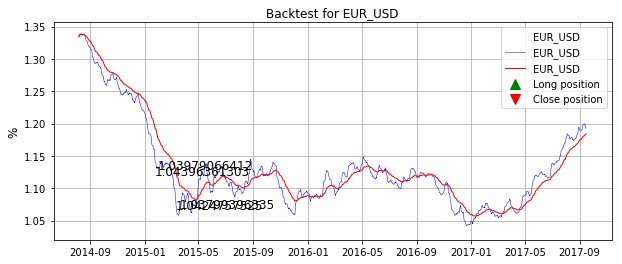

In [36]:
data['ewma'] = data.close.ewm(span=20).mean()
data['ewma2'] = data.close.ewm(span=200).mean()
data['gap'] = data.ewma2 / data.ewma
data['ma_gap_cum'] = data.gap.pct_change(5).cumsum().fillna(0)
rules = (data['ma_gap_cum'] > 0.2) 

data['signal']  = np.where(rules, 1.0, 0.0)
data['action'] = data['signal'].diff().fillna(0)
data['net_cash'] = (data.action*data.close*-1).cumsum()

print(data[data.action!=0][['close','action','net_cash','ma_gap_cum']])

plt.figure(figsize=(10,4))
# plt.plot(data[(data.action==-1)].profit, ls='-', lw=1.5, c='green', label=asset)
plt.plot(data.close, ls='-', lw=0, c='green', label=asset)
plt.plot(data.ewma, ls='-', lw=0.5, c='blue', label=asset)
plt.plot(data.ewma2, ls='-', lw=1, c='red', label=asset)
a = plt.plot(data.close, '^', ms=10, c='green', label='Long position', markevery=inc_loc)
plt.plot(data.close, 'v', ms=10, c='red', label='Close position', markevery=dec_loc)

import random

inc_loc=find_loc(data.close, data[(data.action==1)].index)
dec_loc=find_loc(data.close, data[(data.action==-1)].index)

for location in inc_loc:
    plt.annotate(data.gap[location],
                 (data.index[location], data.close[location]),
                 xytext=(0,0), textcoords='offset points', fontsize=12)

for location in dec_loc:
    plt.annotate(data.gap[location],
                 (data.index[location], data.close[location]),
                 xytext=(0,0), textcoords='offset points', fontsize=12)


plt.grid(True)
plt.legend(loc='best')
plt.title('Backtest for %s' % asset, fontsize=12)
plt.ylabel('%', fontsize=12)

fig1 = plt.gcf()
plt.show()
plt.draw()
# fig1.savefig('%s.png' % asset, dpi=100)